# Library Usage in Seattle, 2005-2020

## Modeling

The data that is the basis for this project is the [Checkouts by Title (Physical Items)](https://data.seattle.gov/Community/Checkouts-By-Title-Physical-Items-/5src-czff) dataset from [Seattle Open Data](https://data.seattle.gov/). It was downloaded on December 15, 2020. Using API calls in [this notebook](0x_api_calls.ipynb), I obtained the rest of the data for the year 2020.

In this notebook, I will be working only with the item checkout counts data created in the [previous (EDA) notebook](02_eda.ipynb). There are 2 versions of this data, one that is missing values for various dates, and one in which those missing values have been imputed (again this process is detailed in the [previous notebook](02_eda.ipynb)). I will mostly be working with the imputed data, but may try using Facebook Prophet in conjunction with the unimputed dataset, since it can handle missing values.

I will look at seasonality, trends, and stationarity in order to create time series models and forecasts for future library use, as well as measure the impact that the COVID-19 pandemic has had on Seattle's libraries.


## Table of contents

1. [Import required packages](#Import-required-packages)
2. [Load data](#Load-data)
3. 

### Import required packages

[[go back to the top](#Library-Usage-in-Seattle,-2005-2020)]

In [9]:
# standard dataframe packages
import pandas as pd; pd.set_option('display.max_columns', 50)
import numpy as np

# graphing packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('ticks')

# time-related packages
import datetime
import holidays

# statistical packages
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.metrics import mean_squared_error

# modeling packages
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# saving packages
import gzip
import pickle

# custom functions
from functions.data_cleaning import *

# reload functions/libraries when edited
%load_ext autoreload
%autoreload 2

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# # may want to use the following:
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM
# from keras.layers import TimeDistributed
# from keras.layers import Flatten
# from keras.layers import Dropout
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D

### Load data

[[go back to the top](#Library-Usage-in-Seattle,-2005-2020)]

In [14]:
# load imputed data
df_imputed = pd.read_pickle('data/seattle_lib_counts_imputed.pkl', compression='gzip')

# load unimputed data
df_unimputed = pd.read_pickle('data/seattle_lib_counts_unimputed.pkl', compression='gzip')

# check shapes
df_imputed.shape, df_unimputed.shape

((5742, 34), (5742, 34))

In [11]:
# take a look
df_imputed.head()

,total_checkouts,missing_title,missing_subjects,format_group_Equipment,format_group_Media,format_group_Other,format_group_Print,format_subgroup_Art,format_subgroup_Audio Disc,format_subgroup_Audio Tape,format_subgroup_Audiobook Disc,format_subgroup_Audiobook Tape,format_subgroup_Book,format_subgroup_Data Disc,format_subgroup_Document,format_subgroup_Film,format_subgroup_Folder,format_subgroup_Kit,format_subgroup_Music Score,format_subgroup_Periodical,format_subgroup_Video Disc,format_subgroup_Video Tape,category_group_Fiction,category_group_Interlibrary Loan,category_group_Language,category_group_Nonfiction,category_group_Other,category_group_Reference,age_group_Adult,age_group_Juvenile,age_group_Teen,day,weekend,holiday
2005-04-13,16471.0,212.0,664.0,1.0,6397.0,32.0,10041.0,0.0,1874.0,63.0,217.0,308.0,9970.0,10.0,0.0,0.0,8.0,97.0,40.0,0.0,1950.0,1878.0,8189.0,32.0,370.0,6719.0,1143.0,18.0,11257.0,4613.0,601.0,Wednesday,0,0
2005-04-14,10358.0,123.0,541.0,1.0,4015.0,75.0,6267.0,0.0,1245.0,31.0,164.0,156.0,6225.0,7.0,0.0,0.0,8.0,85.0,28.0,0.0,1212.0,1115.0,5276.0,73.0,272.0,4104.0,621.0,12.0,6726.0,3381.0,251.0,Thursday,0,0
2005-04-15,12896.0,179.0,508.0,0.0,5351.0,51.0,7494.0,0.0,1462.0,54.0,187.0,239.0,7452.0,12.0,0.0,0.0,4.0,80.0,35.0,0.0,1596.0,1721.0,6357.0,50.0,302.0,5166.0,1014.0,7.0,8795.0,3747.0,354.0,Friday,0,0
2005-04-16,1358.0,7.0,56.0,0.0,552.0,0.0,806.0,0.0,175.0,8.0,31.0,23.0,802.0,1.0,0.0,0.0,2.0,9.0,1.0,0.0,142.0,163.0,567.0,0.0,29.0,666.0,95.0,1.0,950.0,367.0,41.0,Saturday,1,0
2005-04-17,4555.0,80.0,232.0,0.0,1555.0,8.0,2992.0,0.0,499.0,10.0,47.0,96.0,2946.0,9.0,0.0,0.0,7.0,19.0,27.0,0.0,395.0,480.0,2017.0,8.0,177.0,2145.0,203.0,5.0,3035.0,1349.0,171.0,Sunday,1,0


## Check for stationarity

[[go back to the top](#Library-Usage-in-Seattle,-2005-2020)]

#### All data

In [108]:
target = df_imputeda.total_checkouts['2006-01-01':]

In [109]:
year_groups = target.groupby(pd.Grouper(freq='A'))

In [111]:
for yr, group in year_groups:
    print(len(group[:365]))

365
365
365
365
365
365
365
365
365
365
365
365
365
365
365


In [105]:
checkouts_annual

,2005
0,16471.0
1,10358.0
2,12896.0
3,1358.0
4,4555.0
...,...
258,17882.0
259,21368.0
260,17428.0
261,18553.0


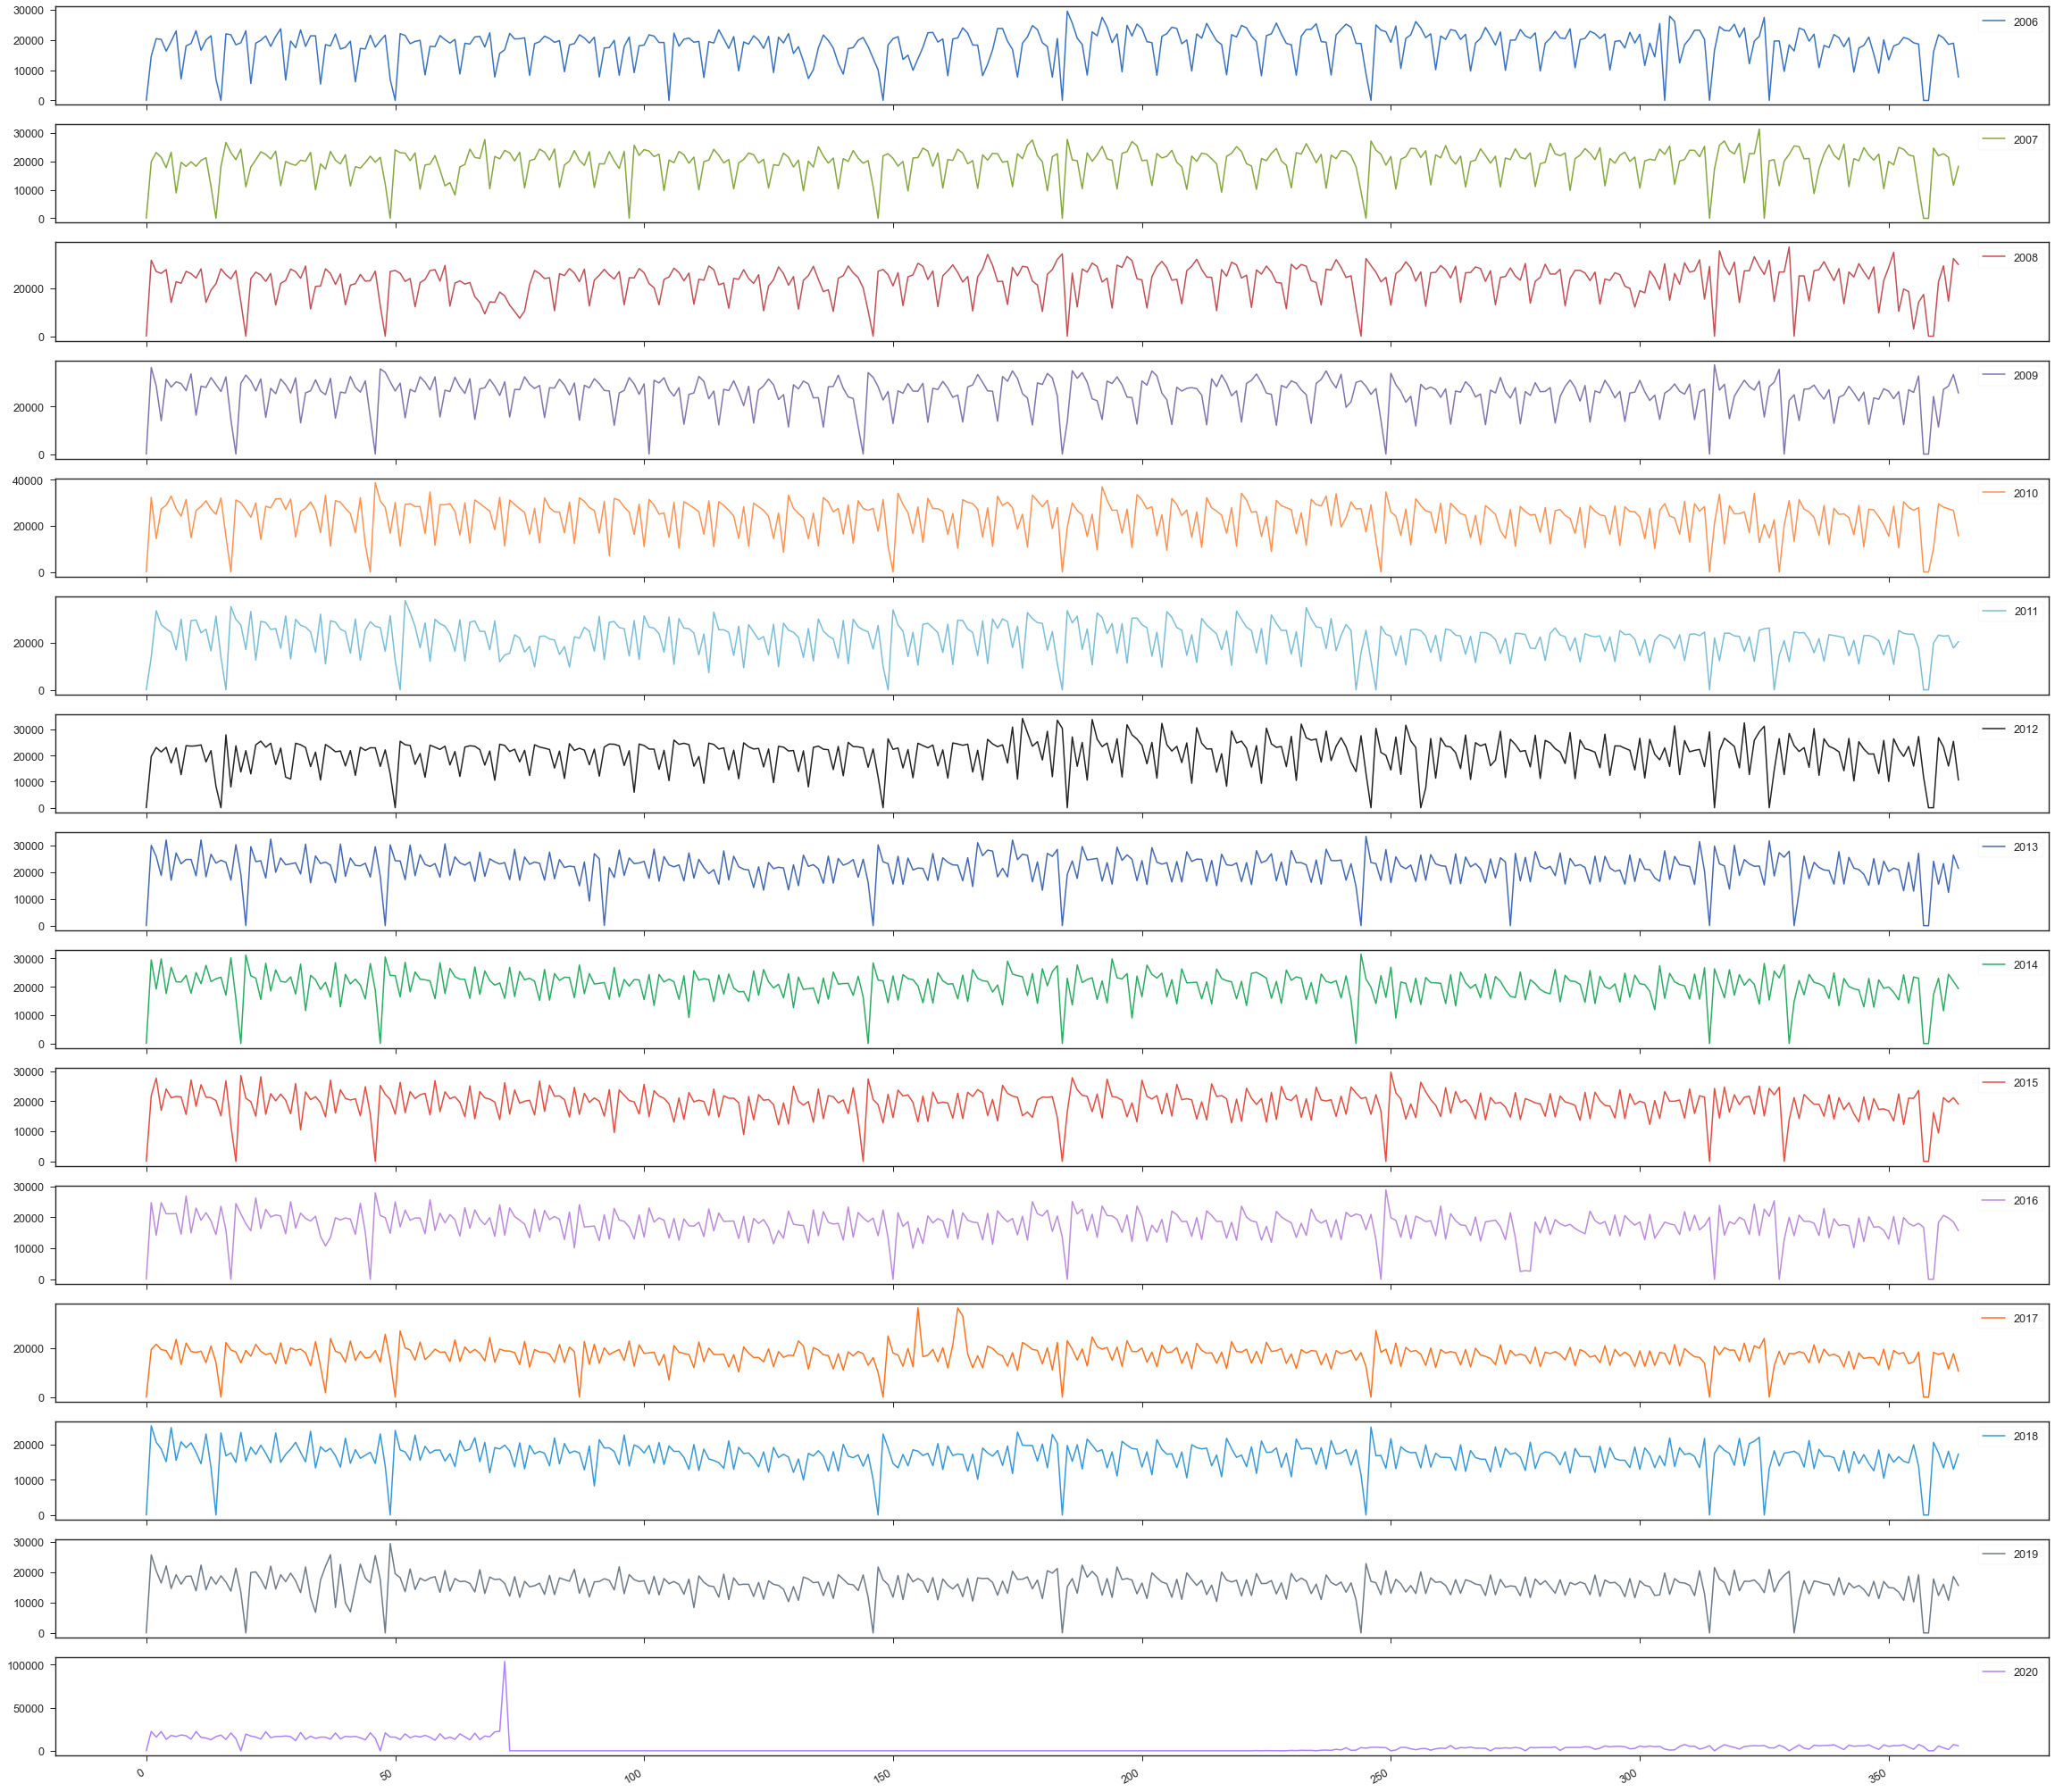

In [113]:
# Create a new DataFrame and store yearly values in columns  
checkouts_annual = pd.DataFrame() 
for yr, group in year_groups:
    checkouts_annual[yr.year] = group[:365].values.ravel()
# Plot the yearly groups as subplots
checkouts_annual.plot(figsize=(40,40), subplots=True, legend=True)
plt.show()

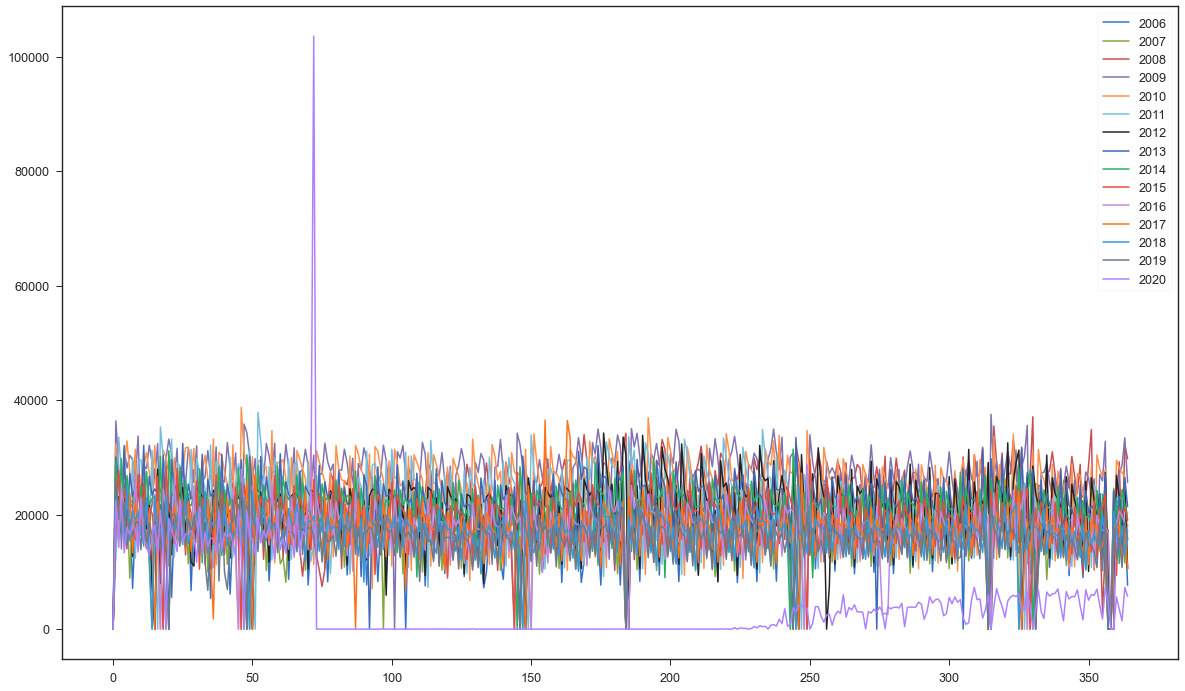

In [114]:
# Plot all years on the same graph
checkouts_annual.plot(figsize = (20,12), subplots=False, legend=True)
plt.show()

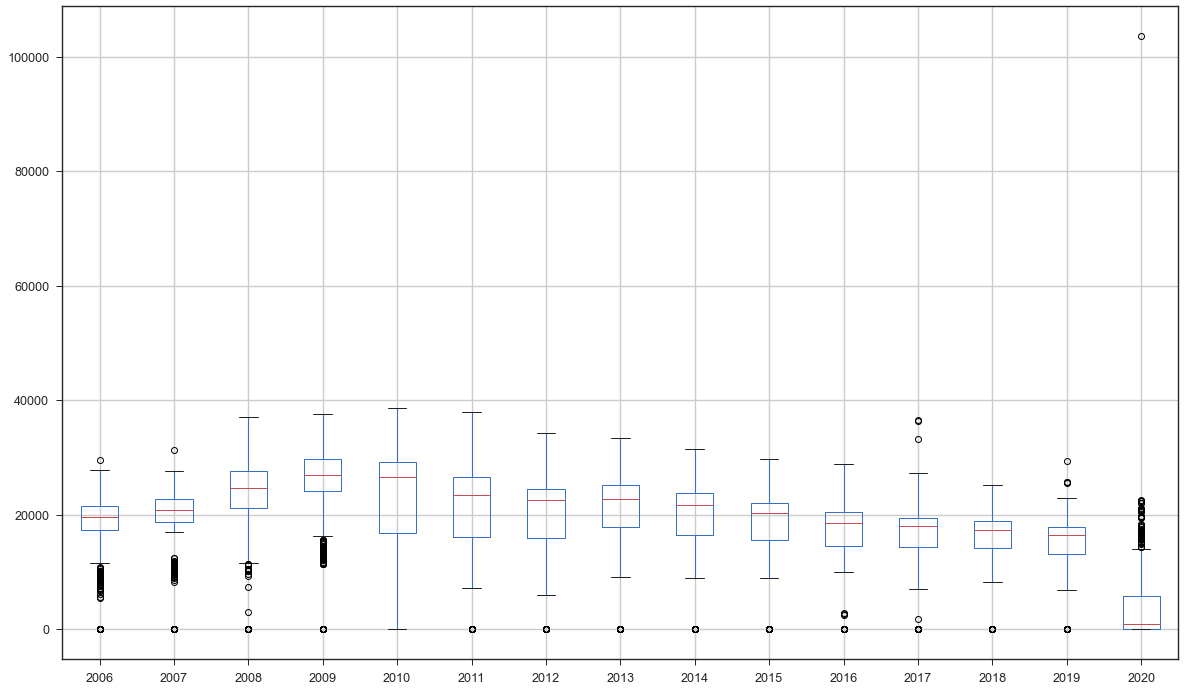

In [115]:
# Plot all years on the same graph
checkouts_annual.boxplot(figsize=(20,12))
plt.show()

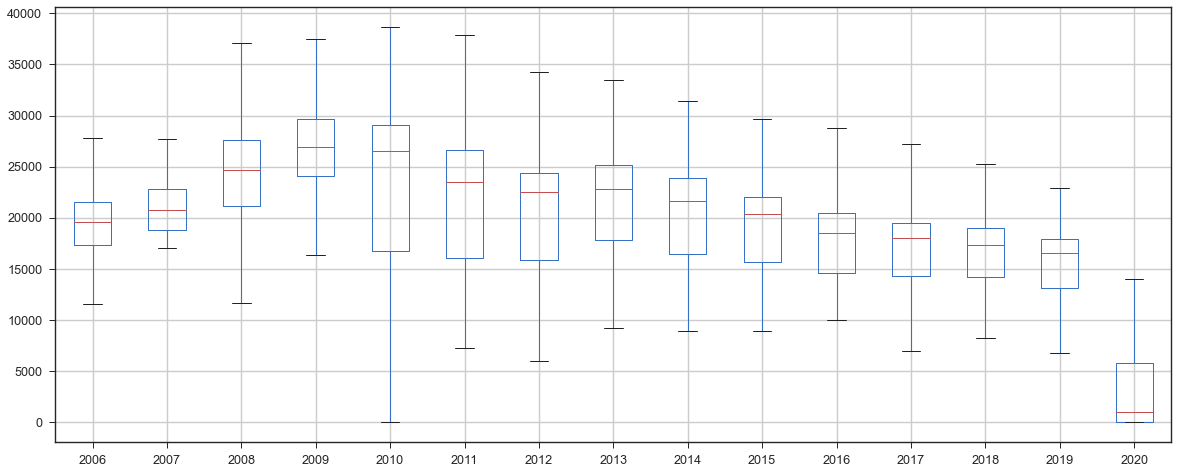

In [117]:
# Plot all years on the same graph
checkouts_annual.boxplot(figsize=(20,8), showfliers=False)
plt.show()

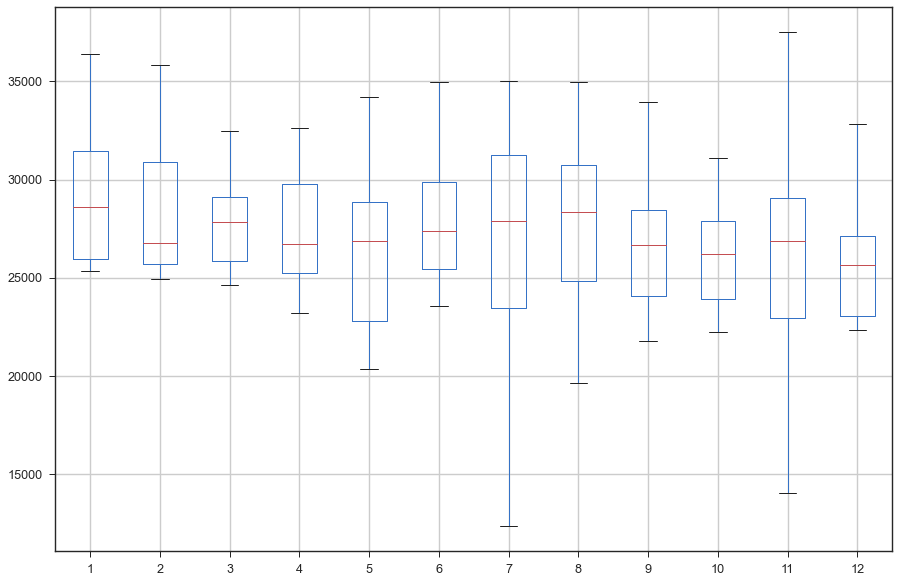

In [140]:
# Use temp_data to extract values for 2009
yr_2009 = target['2009']
# Group observations by month
groups_monthly = yr_2009.groupby(pd.Grouper(freq ='M'))
# Add each month to DataFrame as a column
months_2009 = pd.concat([pd.DataFrame(x[1].values) for x in groups_monthly], axis=1)
months_df = pd.DataFrame(months_2009)
# Set the column names for each month i.e. 1,2,3, .., 12
months_df.columns = range(1,13)
# Plot the box and whiskers plot for each month 
months_df.boxplot(figsize = (15,10), showfliers=False)
plt.show()

In [62]:
X = target.values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=21026.885754, mean2=16461.953675
variance1=54339466.912758, variance2=52437955.800362


In [63]:
df_test = adfuller(target)
dfoutput = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
print(dfoutput)

Test Statistic                   -1.631459
p-value                           0.466727
#Lags Used                       34.000000
Number of Observations Used    5707.000000
dtype: float64


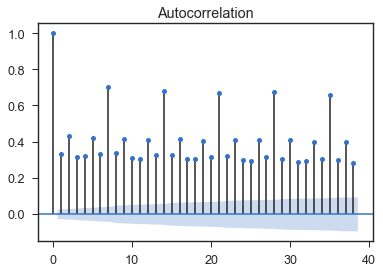

In [64]:
plot_acf(target, alpha=.05);

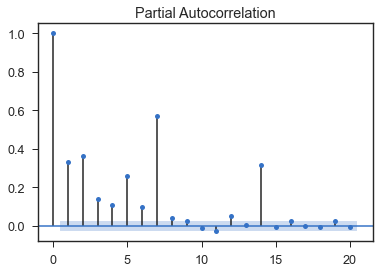

In [65]:
plot_pacf(target, alpha=.05, lags=20);

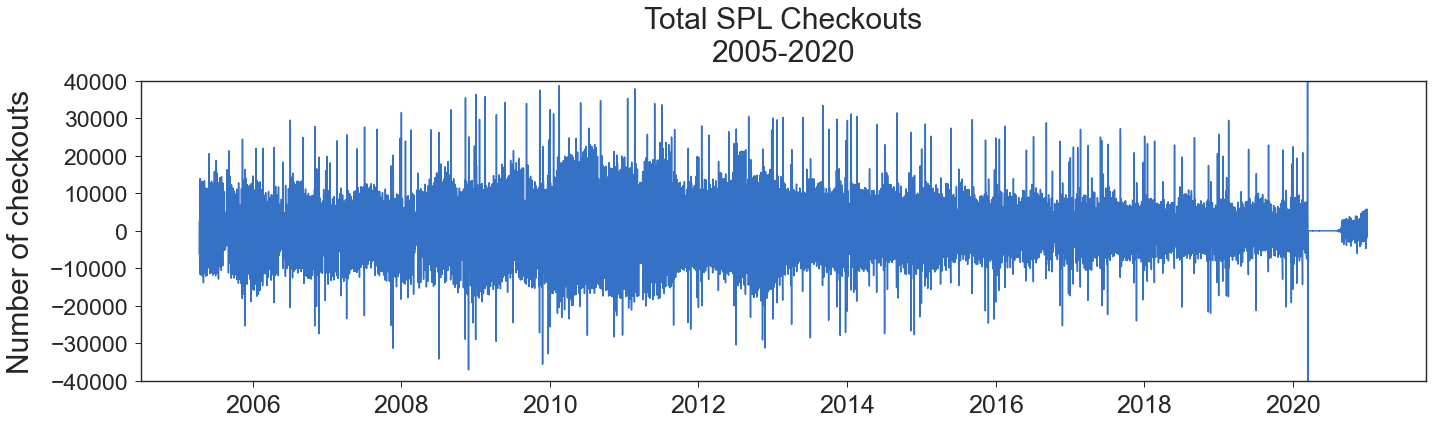

In [66]:
# get differenced values
diff = target.diff()

# instantiate figure
plt.figure(figsize=(20,6))

# prettify plot
plt.title(f'Total SPL Checkouts\n2005-2020', fontsize=30, pad=20)
plt.ylabel('Number of checkouts', fontsize=30, labelpad=15)
plt.xticks(fontsize=25)
plt.yticks(fontsize=23)
plt.ylim(bottom=-40000, top=40000)

# plot
plt.plot(diff)

# prepare to save and display
plt.tight_layout()

# # uncomment to save
plt.savefig('charts/ts_modeling/total_checkouts_differenced_line.png', 
            bbox_inches='tight', transparent=True)

plt.show()

In [67]:
df_test = adfuller(diff[1:])
dfoutput = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
print(dfoutput)

Test Statistic                  -19.924555
p-value                           0.000000
#Lags Used                       34.000000
Number of Observations Used    5706.000000
dtype: float64


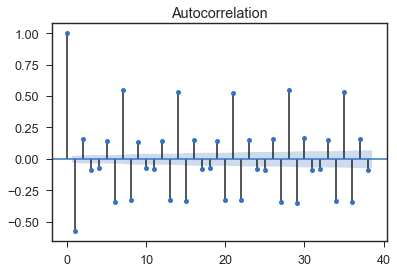

In [68]:
plot_acf(diff[1:], alpha=.05);

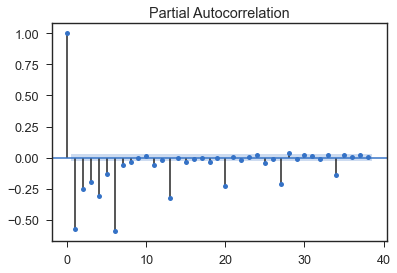

In [69]:
plot_pacf(diff[1:], alpha=.05);

#### Data before March 13

In [78]:
target = df_imputed.total_checkouts[:'2020-03-12']
X = target.values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=21022.584435, mean2=18271.298458
variance1=54498466.225984, variance2=29073096.868705


In [55]:
df_test = adfuller(target)
dfoutput = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
print(dfoutput)

Test Statistic                   -3.690726
p-value                           0.004246
#Lags Used                       28.000000
Number of Observations Used    5419.000000
dtype: float64


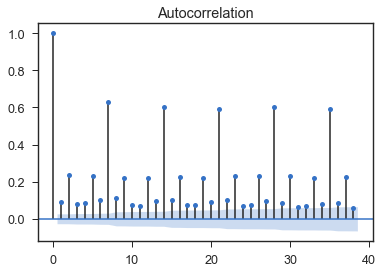

In [56]:
plot_acf(target, alpha=.05);

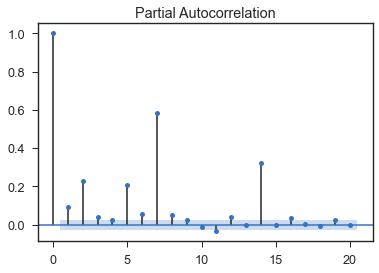

In [57]:
plot_pacf(target, alpha=.05, lags=20);

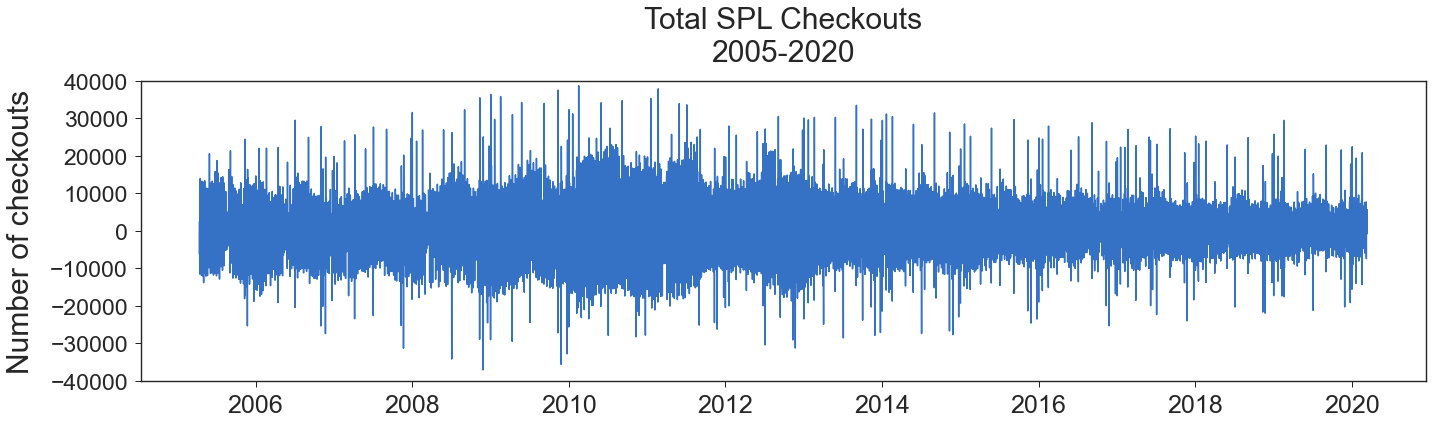

In [58]:
# get differenced values
diff = target.diff()

# instantiate figure
plt.figure(figsize=(20,6))

# prettify plot
plt.title(f'Total SPL Checkouts\n2005-2020', fontsize=30, pad=20)
plt.ylabel('Number of checkouts', fontsize=30, labelpad=15)
plt.xticks(fontsize=25)
plt.yticks(fontsize=23)
plt.ylim(bottom=-40000, top=40000)

# plot
plt.plot(diff)

# prepare to save and display
plt.tight_layout()

# # uncomment to save
plt.savefig('charts/ts_modeling/total_checkouts_differenced_pre-pandemic_line.png', 
            bbox_inches='tight', transparent=True)

plt.show()

In [59]:
df_test = adfuller(diff[1:])
dfoutput = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
print(dfoutput)

Test Statistic                  -21.792329
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5413.000000
dtype: float64


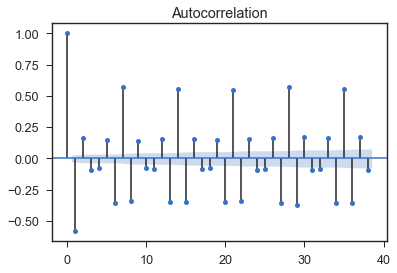

In [60]:
plot_acf(diff[1:], alpha=.05);

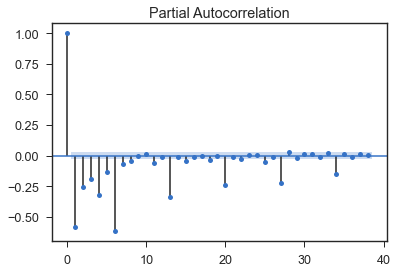

In [61]:
plot_pacf(diff[1:], alpha=.05);

In [79]:
seasonal_decompose(target)

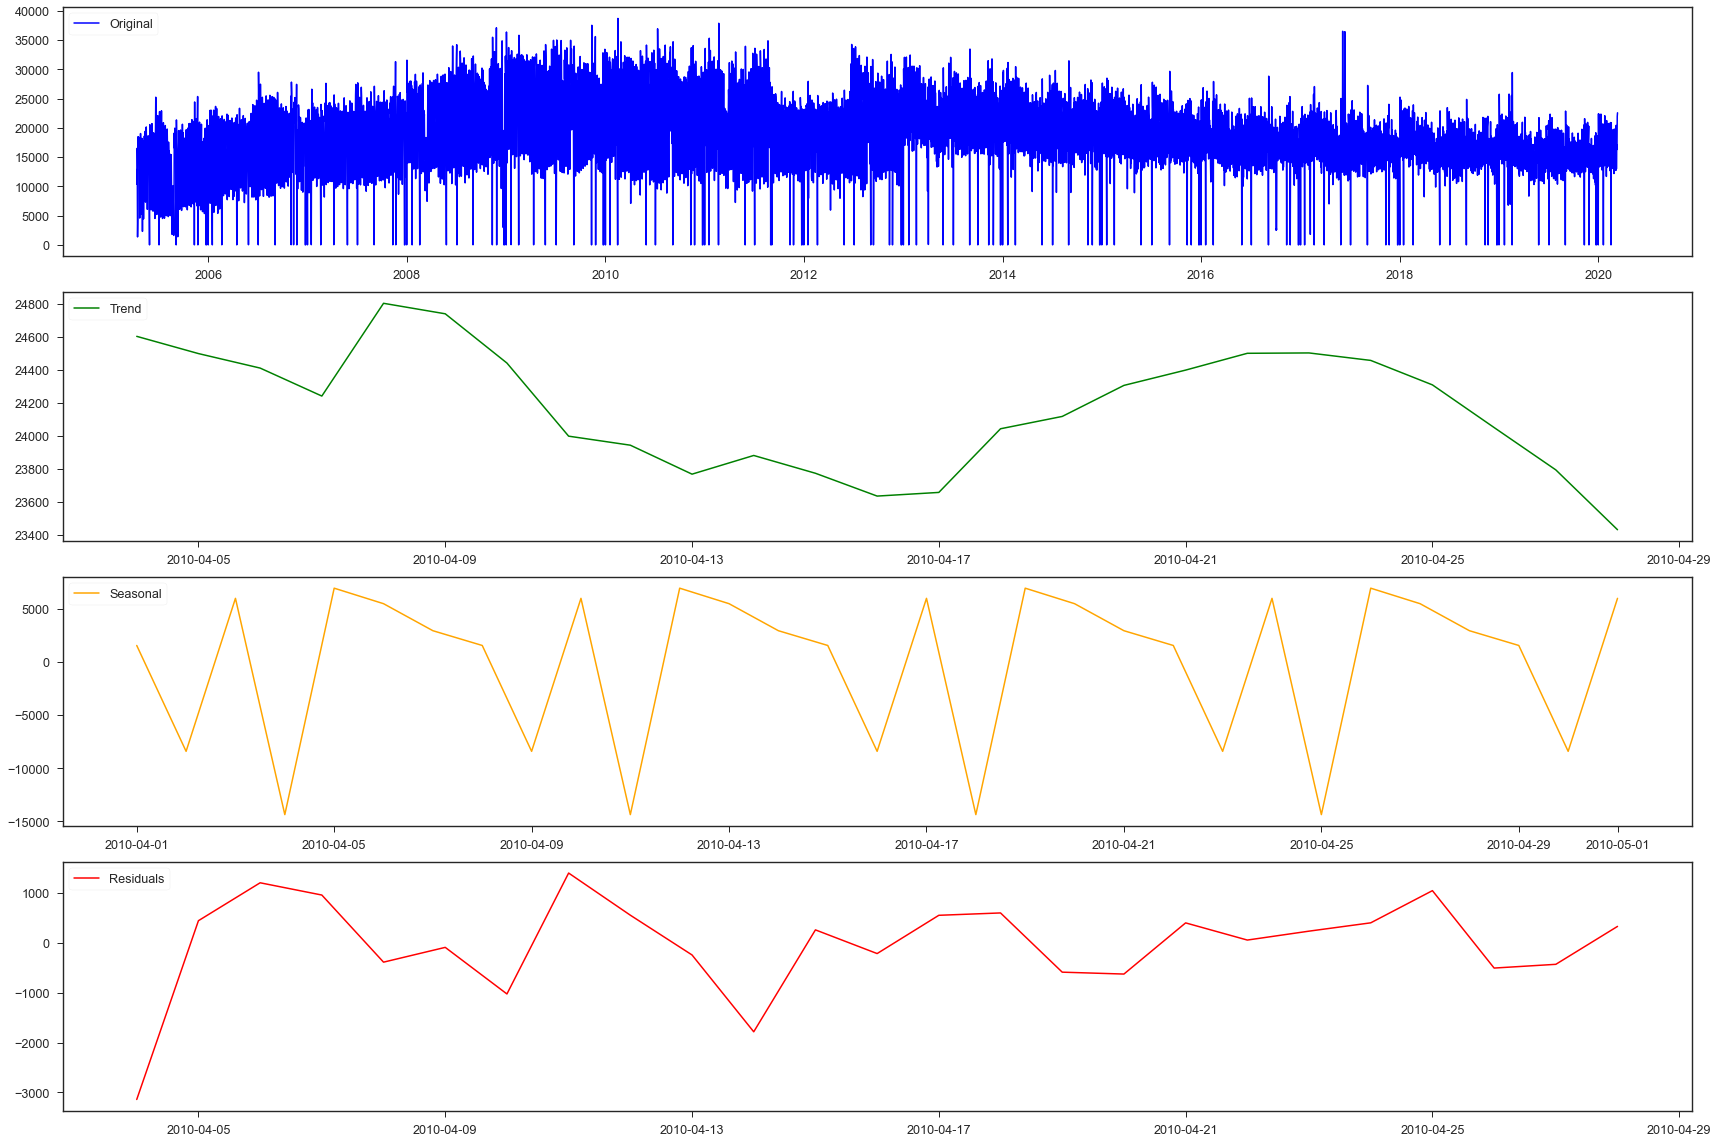

In [86]:
decomposition = seasonal_decompose(target['2010-04-01':'2010-05-01'])

trend = decomposition.trend
seasonal = decomposition.seasonal
residuals = decomposition.resid

plt.figure(figsize=(24,16))
plt.subplot(411)
plt.plot(target,label='Original',color='blue')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend,label='Trend',color='green')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonal',color='orange')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residuals,label='Residuals',color='red')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [146]:
target = df_imputed.total_checkouts[:'2020-03-12']

# Determine rolling statistics
roll_mean = target.rolling(window=12, center=False).mean()
roll_std = target.rolling(window=12, center=False).std()

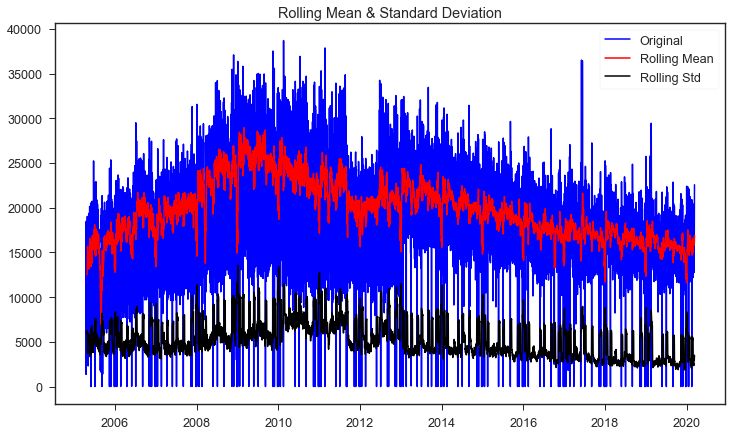

In [147]:
# Plot rolling statistics
fig = plt.figure(figsize=(12,7))
plt.plot(target, color='blue', label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

# GRAVEYARD

[[go back to the top](#Library-Usage-in-Seattle,-2005-2020)]

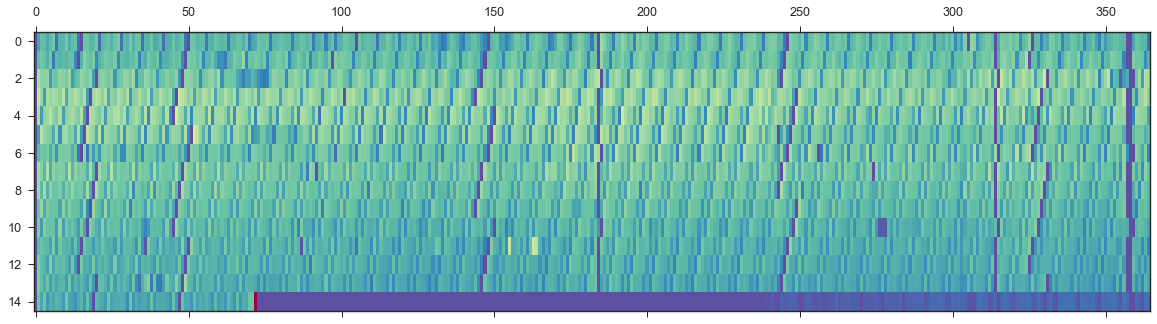

In [126]:
# Transpose the yearly group DataFrame
year_matrix = checkouts_annual.T
# Draw a heatmap with matshow()
plt.figure(figsize=(20,5))
plt.matshow(year_matrix, interpolation=None, aspect='auto', cmap=plt.cm.Spectral_r, fignum=1)
plt.show()

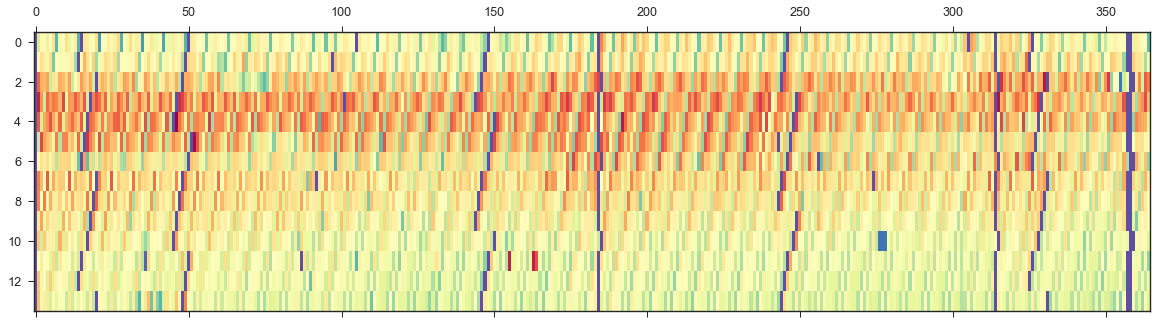

In [135]:
# Transpose the yearly group DataFrame
year_matrix = checkouts_annual[range(2006,2020)].T
# Draw a heatmap with matshow()
plt.figure(figsize=(20,5))
plt.matshow(year_matrix, interpolation=None, aspect='auto', cmap=plt.cm.Spectral_r, fignum=1)
plt.show()

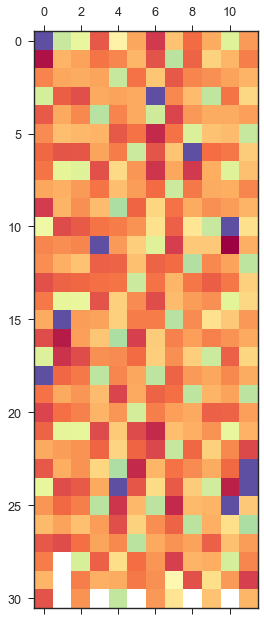

In [141]:
# Draw a heatmap comparing the months of the year in 1990 
plt.matshow(months_df, interpolation=None, aspect='auto', cmap=plt.cm.Spectral_r)
plt.show()

## Autocorrelation

#### What is autocorrleation? 

It is the correlation between one time series and the same time series shifted by k periods. 

In [72]:
checkouts_lag_1 = target['2010-01-01':'2010-12-31'].shift(periods=1)
checkouts_lag_2 = target['2010-01-01':'2010-12-31'].shift(periods=2)
checkouts_lag_3 = target['2010-01-01':'2010-12-31'].shift(periods=3)

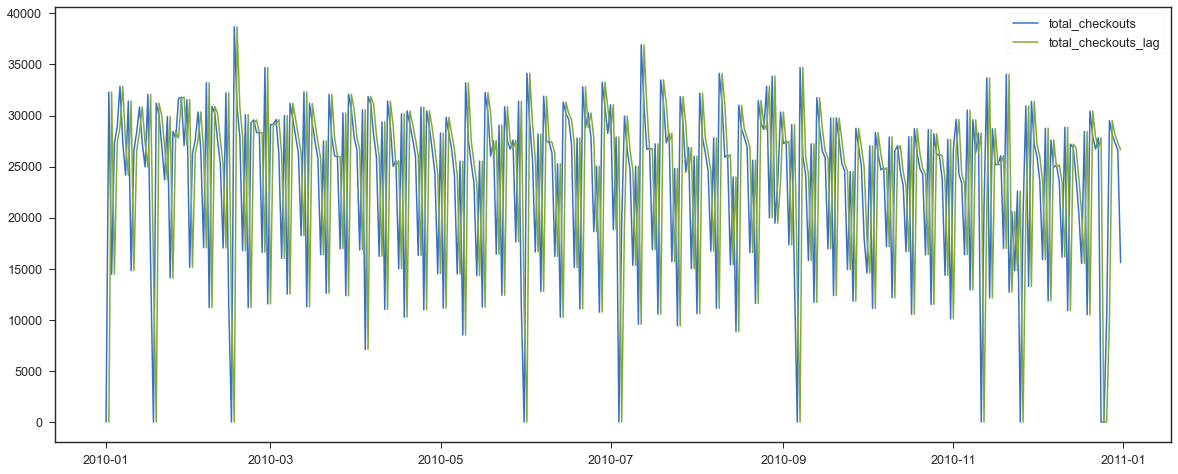

In [75]:
plt.figure(figsize=(20,8))
plt.plot(target['2010-01-01':'2010-12-31'])
plt.plot(checkouts_lag_1)
plt.legend(['total_checkouts', 'total_checkouts_lag']);

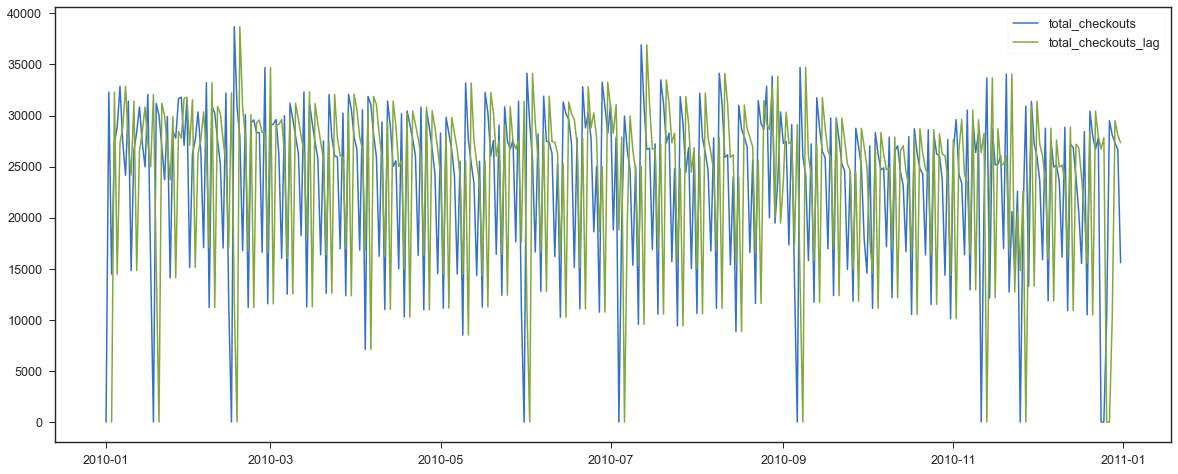

In [76]:
plt.figure(figsize=(20,8))
plt.plot(target['2010-01-01':'2010-12-31'])
plt.plot(checkouts_lag_2)
plt.legend(['total_checkouts', 'total_checkouts_lag']);

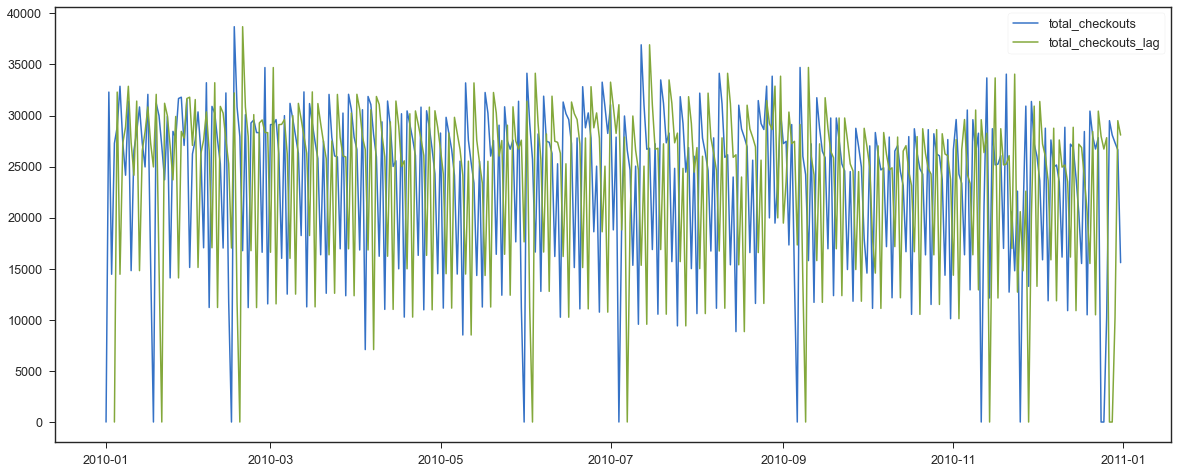

In [77]:
plt.figure(figsize=(20,8))
plt.plot(target['2010-01-01':'2010-12-31'])
plt.plot(checkouts_lag_3)
plt.legend(['total_checkouts', 'total_checkouts_lag']);